### we need tensorflow and keras at least

In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../")

from src.enzyme_hackathon.utils import (one_hot_dict, one_hot_encode, one_hot_encode_screening_data,
                                        one_hot_encode_sequences)
from src.enzyme_hackathon.utils import AA_LABELS

Using TensorFlow backend.


In [3]:
from src.enzyme_hackathon.utils import (create_fc_model, predict, generate_variant, r_squared, nan_mse)

In [4]:
regression_df = pd.read_csv("../data/raw/challenge-0.csv")
df1 = pd.read_csv("../data/raw/challenge-1.csv")
df2 = pd.read_csv("../data/raw/challenge-2.csv")
print(regression_df.describe(), df1.describe(), df2.describe())

        Unnamed: 0  performance    stability  productivity      fitness
count  7000.000000  6896.000000  6878.000000   7000.000000  6878.000000
mean   4010.524714     0.984543     0.781275      1.215665     0.898539
std    2299.783102     0.283531     0.324650      0.462164     0.491000
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%    2026.750000     0.911732     0.499931      0.992109     0.494338
50%    4000.500000     0.997816     0.841235      1.016482     0.891317
75%    5999.250000     1.169030     1.000279      1.501715     1.266698
max    7999.000000     2.253050     2.493611      3.035927     1.940561         Unnamed: 0  performance    stability  productivity      fitness
count  9906.000000  9838.000000  9719.000000   9906.000000  9906.000000
mean   5001.255704     1.077744     1.093033      1.173327     1.330397
std    2884.806712     0.331799     0.317386      0.356221     0.515413
min       1.000000     0.000000     0.000000      0.000000     0

In [5]:
from collections import OrderedDict
encoded_split_dict = one_hot_encode_screening_data(regression_df)
x_train, x_test = (encoded_split_dict['x'][0], encoded_split_dict['x'][1])
y_keys = [key for key in encoded_split_dict['y'].keys()]

y_train, y_test = (OrderedDict(), OrderedDict())
for y_key in y_keys:
    y_train[y_key], y_test[y_key] = (encoded_split_dict['y'][y_key]['data'][0], encoded_split_dict['y'][y_key]['data'][1])

## Regression for the challenge 0

In [6]:
import keras


In [40]:
from keras import backend as K
from keras import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

def create_fc_model(data: dict):
    """Create a multi-task fully connected neural network model

    :param data:
    :return:
    """
    sequence_input = Input(shape=data['x'][0][0].shape, name='sequence')
    sequence = Flatten()(sequence_input)

    sequence = Dense(50, activation='relu', kernel_regularizer=l2(1.1))(sequence)
    sequence = Dropout(.1)(sequence)
    
#     sequence = Dense(50, activation='relu', kernel_regularizer=l2(1.1))(sequence)
#     sequence = Dropout(.1)(sequence)

    outputs = []
    for task, _ in data['y'].items():
        t = Dense(20, activation='relu', kernel_regularizer=l2(1.1))(sequence)
        t = Dropout(.1)(t)
        t = BatchNormalization()(t)
        outputs.append(Dense(1, name=task)(t))

    model = Model(inputs=[sequence_input], outputs=outputs)
    model.compile(loss=nan_mse, 
                  optimizer=Adam(lr=0.0001),
                  metrics=[r_squared])
    return model

In [41]:
fc_nn = create_fc_model(encoded_split_dict)
# for key in y_test.keys():
#     y_train_tuples = [(x.tolist()[0], y.tolist()[0], z.tolist()[0]) for x, y, z in zip(y_train[y_keys[0]], y_train[y_keys[1]], y_train[y_keys[2]])]

In [42]:
import keras
fcCallbacks = keras.callbacks.TensorBoard(log_dir='../logs', 
                                          histogram_freq=0,
                                          write_graph=True, 
                                          write_images=True)

In [43]:
fc_nn.fit(x=x_train,
          y=[y_train['productivity'], y_train['performance'], y_train['stability']],
         epochs=50, batch_size=32, callbacks=[fcCallbacks])

Epoch 1/50
5250/5250 [==============================] - 3s 580us/step - loss: 149.7590 - productivity_loss: 1.3864 - performance_loss: 1.3884 - stability_loss: 1.1166 - productivity_r_squared: 0.0263 - performance_r_squared: 0.0129 - stability_r_squared: 0.0656
Epoch 2/50
5250/5250 [==============================] - 2s 299us/step - loss: 90.6554 - productivity_loss: 0.7387 - performance_loss: 0.7418 - stability_loss: 0.6313 - productivity_r_squared: 0.2513 - performance_r_squared: 0.2277 - stability_r_squared: 0.3437
Epoch 3/50
5250/5250 [==============================] - 2s 288us/step - loss: 69.5729 - productivity_loss: 0.5638 - performance_loss: 0.5359 - stability_loss: 0.4561 - productivity_r_squared: 0.4091 - performance_r_squared: 0.4283 - stability_r_squared: 0.5188
Epoch 4/50
5250/5250 [==============================] - 1s 283us/step - loss: 57.4487 - productivity_loss: 0.4707 - performance_loss: 0.4424 - stability_loss: 0.3704 - productivity_r_squared: 0.5004 - performance_r_s

In [61]:
fc_nn.save("../models/FCNN_50_ADAM.hfd5")

# Predictions on test set

In [48]:
pred_productivity, pred_performance, pred_stability = fc_nn.predict(x_test)

In [55]:
import matplotlib.pyplot as plt

(array([ 28.,  48.,  31., 644., 227., 226., 343.,  72., 104.,  27.]),
 array([-1.9349555 , -1.487417  , -1.0398785 , -0.59233993, -0.14480145,
         0.30273706,  0.75027555,  1.1978141 ,  1.6453526 ,  2.092891  ,
         2.5404296 ], dtype=float32),
 <a list of 10 Patch objects>)

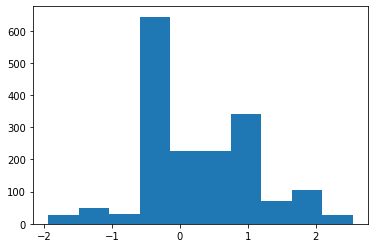

In [56]:
plt.hist(pred_productivity)

(array([ 17.,  48.,  86.,  94., 218., 777., 169., 224.,  94.,  23.]),
 array([-2.9160564 , -2.4008226 , -1.8855888 , -1.3703549 , -0.8551211 ,
        -0.33988726,  0.17534657,  0.69058037,  1.2058142 ,  1.721048  ,
         2.2362819 ], dtype=float32),
 <a list of 10 Patch objects>)

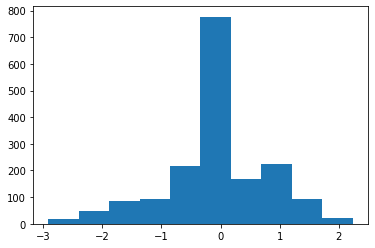

In [57]:
plt.hist(pred_performance)

(array([ 31., 226., 333.,  47., 330., 631.,  42.,  34.,  73.,   3.]),
 array([-2.0245638 , -1.5600779 , -1.095592  , -0.6311061 , -0.16662017,
         0.29786575,  0.76235163,  1.2268375 ,  1.6913235 ,  2.1558094 ,
         2.6202953 ], dtype=float32),
 <a list of 10 Patch objects>)

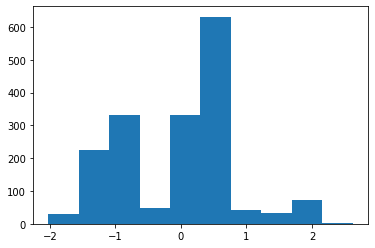

In [58]:
plt.hist(pred_stability)